In [ ]:
!kaggle competitions download -c playground-series-s5e2
!kaggle datasets download souradippal/student-bag-price-prediction-dataset

!unzip -u *.zip

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import missingno

from sklearn import set_config
set_config(transform_output = "pandas")

from sklearn.model_selection import ShuffleSplit, KFold
from sklearn.model_selection import cross_validate

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, TargetEncoder
from sklearn.impute import KNNImputer

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

KAGGLE_RUN = False
if KAGGLE_RUN:
    working_dir = Path('/kaggle/input/playground-series-s5e2')
else:
    working_dir = Path().cwd()


In [3]:
train_df = pd.concat([
    pd.read_csv(working_dir/'train.csv'),
    pd.read_csv(working_dir/'training_extra.csv')
    ], axis=0, ignore_index=True)

test_df = pd.read_csv(working_dir/'test.csv')

original_df = pd.read_csv(working_dir/'Noisy_Student_Bag_Price_Prediction_Dataset.csv')

train_df

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312
...,...,...,...,...,...,...,...,...,...,...,...
3994313,4194313,Nike,Canvas,NaN,3.0,Yes,Yes,Messenger,Blue,28.098120,104.74460
3994314,4194314,Puma,Leather,Small,10.0,Yes,Yes,Tote,Blue,17.379531,122.39043
3994315,4194315,Jansport,Canvas,Large,10.0,No,No,Backpack,Red,17.037708,148.18470
3994316,4194316,Puma,Canvas,NaN,2.0,No,No,Backpack,Gray,28.783339,22.32269


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3994318 entries, 0 to 3994317
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Brand                 object 
 2   Material              object 
 3   Size                  object 
 4   Compartments          float64
 5   Laptop Compartment    object 
 6   Waterproof            object 
 7   Style                 object 
 8   Color                 object 
 9   Weight Capacity (kg)  float64
 10  Price                 float64
dtypes: float64(3), int64(1), object(7)
memory usage: 335.2+ MB


In [5]:
CATEGORIC_COLUMNS = ['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']
NUMERIC_COLUMNS = ['Weight Capacity (kg)']
TARGET_COLUMN = ['Price']

In [6]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52500 entries, 0 to 52499
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Brand                 49875 non-null  object 
 1   Material              49875 non-null  object 
 2   Size                  49875 non-null  object 
 3   Compartments          49875 non-null  float64
 4   Laptop Compartment    49875 non-null  object 
 5   Waterproof            49875 non-null  object 
 6   Style                 49875 non-null  object 
 7   Color                 49875 non-null  object 
 8   Weight Capacity (kg)  49875 non-null  float64
 9   Price                 49875 non-null  float64
dtypes: float64(3), object(7)
memory usage: 4.0+ MB


In [39]:
missing_values_train = pd.DataFrame({
    'Feature': original_df.columns,
    'No. of Missing Values': original_df.isnull().sum().values,
    '% of Missing Values': ((original_df.isnull().sum().values)/len(original_df)*100)
    })
missing_values_train

,Feature,No. of Missing Values,% of Missing Values
0,Brand,2625,5.0
1,Material,2625,5.0
2,Size,2625,5.0
3,Compartments,2625,5.0
4,Laptop Compartment,2625,5.0
5,Waterproof,2625,5.0
6,Style,2625,5.0
7,Color,2625,5.0
8,Weight Capacity (kg),2625,5.0
9,Price,2625,5.0


<Axes: >

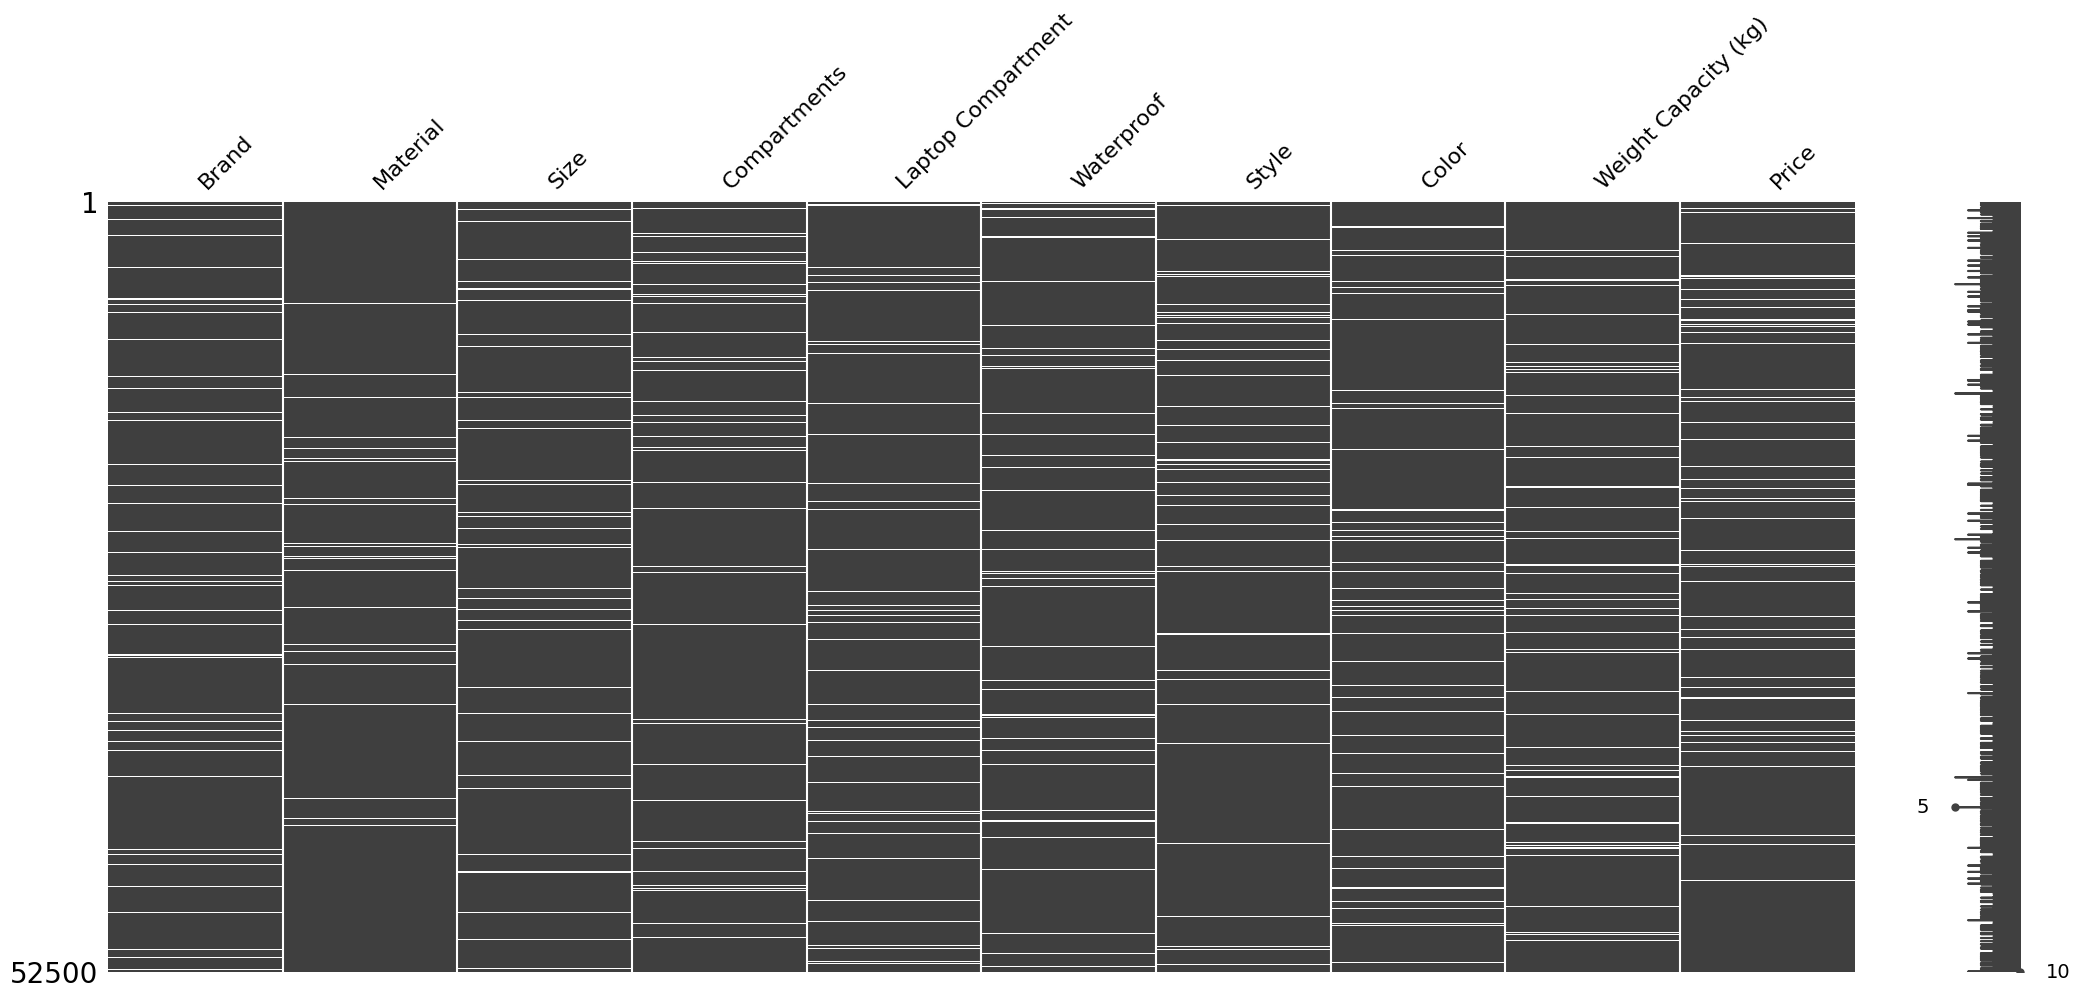

In [40]:
missingno.matrix(original_df)

In [21]:
test = train_df.loc[train_df.isna().any(axis=1)].iloc[1]
test

id                             6
Brand                       Nike
Material                     NaN
Size                       Large
Compartments                 3.0
Laptop Compartment            No
Waterproof                    No
Style                   Backpack
Color                      Green
Weight Capacity (kg)    6.828123
Price                     84.805
Name: 6, dtype: object

In [25]:
original_df.loc[
    (test.Brand == original_df.Brand) &
    # (test.Material == original_df.Material) &
    (test.Size == original_df.Size) &
    (test.Compartments == original_df.Compartments) &
    (test['Laptop Compartment'] == original_df['Laptop Compartment']) &
    (test['Waterproof'] == original_df['Waterproof']) &
    (test['Style'] == original_df['Style']) & 
    (test['Color'] == original_df['Color']) 
    ]

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
26881,Nike,Canvas,Large,3.0,No,No,Backpack,Green,30.000000,94.582480
34435,Nike,Canvas,Large,3.0,No,No,Backpack,Green,7.428661,41.331863
41994,Nike,Leather,Large,3.0,No,No,Backpack,Green,25.644787,60.725373
43333,Nike,Leather,Large,3.0,No,No,Backpack,Green,17.362048,21.575280
45082,Nike,Leather,Large,3.0,No,No,Backpack,Green,6.682818,19.720490
50048,Nike,Canvas,Large,3.0,No,No,Backpack,Green,29.575942,98.961600


In [36]:
train_df.groupby(
    by=CATEGORIC_COLUMNS
).agg(
        unique_categories=('Price', 'nunique'),
        mean=('Price', 'mean'),
        std=('Price', 'std'),
        ).reset_index()

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,unique_categories,mean,std
0,Adidas,Canvas,Large,1.0,No,No,Backpack,Black,63,81.349507,37.924847
1,Adidas,Canvas,Large,1.0,No,No,Backpack,Blue,64,77.523077,36.067441
2,Adidas,Canvas,Large,1.0,No,No,Backpack,Gray,78,81.148602,39.429881
3,Adidas,Canvas,Large,1.0,No,No,Backpack,Green,66,83.518365,35.642177
4,Adidas,Canvas,Large,1.0,No,No,Backpack,Pink,65,82.840767,40.258676
...,...,...,...,...,...,...,...,...,...,...,...
43195,Under Armour,Polyester,Small,10.0,Yes,Yes,Tote,Blue,72,85.505308,38.950934
43196,Under Armour,Polyester,Small,10.0,Yes,Yes,Tote,Gray,78,85.029688,38.965118
43197,Under Armour,Polyester,Small,10.0,Yes,Yes,Tote,Green,83,84.356604,39.303169
43198,Under Armour,Polyester,Small,10.0,Yes,Yes,Tote,Pink,87,84.949385,41.208566


In [37]:
original_df.groupby(
    by=CATEGORIC_COLUMNS
).agg(
        unique_categories=('Price', 'nunique'),
        mean=('Price', 'mean'),
        std=('Price', 'std'),
        ).reset_index()

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,unique_categories,mean,std
0,Adidas,Canvas,Large,1.0,No,No,Backpack,Blue,1,133.016652,NaN
1,Adidas,Canvas,Large,1.0,No,No,Backpack,Green,1,150.000000,NaN
2,Adidas,Canvas,Large,1.0,No,No,Backpack,Red,1,134.157664,NaN
3,Adidas,Canvas,Large,1.0,No,No,Messenger,Black,2,68.628128,20.973470
4,Adidas,Canvas,Large,1.0,No,No,Messenger,Green,1,125.923354,NaN
...,...,...,...,...,...,...,...,...,...,...,...
23653,Under Armour,Polyester,Small,10.0,Yes,Yes,Messenger,Green,3,107.817735,56.601367
23654,Under Armour,Polyester,Small,10.0,Yes,Yes,Messenger,Red,1,130.867102,NaN
23655,Under Armour,Polyester,Small,10.0,Yes,Yes,Tote,Black,1,131.917657,NaN
23656,Under Armour,Polyester,Small,10.0,Yes,Yes,Tote,Blue,2,136.692302,18.819928
